In [1]:
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from nltk.util import ngrams
import re
import warnings
warnings.filterwarnings("ignore")

# nltk packages to download
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# Data to use
adhd_csv = "data/ADHD/adhd.csv"
comparison_list = ["voices", "hallucination", "intrusive thoughts",
                   "OCD", "obsession", "compulsion", "ritual",]
                   #"workout", "exercise", "gym", "lifting", "running", "cardio"]
additional_stopwords = ["i", "i'm" "i`m", "i’m", "like", "and", "of", "to", "a", "in"]

trigger_words = ["voices", "ocd", "workout"]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/derekburrola/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/derekburrola/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
def preprocess_text(text, gram_size):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words and len(word) > 3]

    if gram_size == 1:
        return words
    else:
        grams = list(ngrams(words, gram_size))
        gram_strings = ["_".join(gram) for gram in grams]
        return gram_strings

def getVectorizedData(df, gram_size, vectorizer):
    processed_df = df["body"].apply(lambda text: preprocess_text(text, gram_size))
    processed_text = processed_df.apply(lambda x: " ".join(x))
    X = vectorizer.fit_transform(processed_text)
    return X

def prepare_plot_data(X, k, vectorizer):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(X)
    word_clusters = {word: cluster for word, cluster in zip(vectorizer.get_feature_names_out(), kmeans.labels_)}

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.toarray())

    # Create a DataFrame for visualization
    pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    pca_df["Cluster"] = kmeans.labels_

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(X.toarray())

    # Create a DataFrame
    tsne_df = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])
    tsne_df["Cluster"] = kmeans.labels_

    return pca_df, tsne_df, word_clusters

def plot_data(pca_df, tsne_df, title_post):
    # Plot the clusters using PCA and t-SNE
        plt.figure(figsize=(15, 6))

        # Scatter plot for PCA
        plt.subplot(1,2,1)
        sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="viridis")
        plt.title(f"KMeans Clusters (PCA {title_post})")

        # Scatter plot for t-SNE
        plt.subplot(1,2,2)
        sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="Cluster", palette="tab10")
        plt.title(f"KMeans Clusters (t-SNE {title_post})")
        plt.show()

def plot_wordcloud(word_cluster, k):
    plt.figure(figsize=(20, 8))
    for cluster_id in range(k):
        cluster_words = [word for word, cluster in word_cluster.items() if cluster == cluster_id]
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(cluster_words))

        plt.subplot(1,k,cluster_id+1)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Cluster {cluster_id} Word Cloud")
    plt.show()


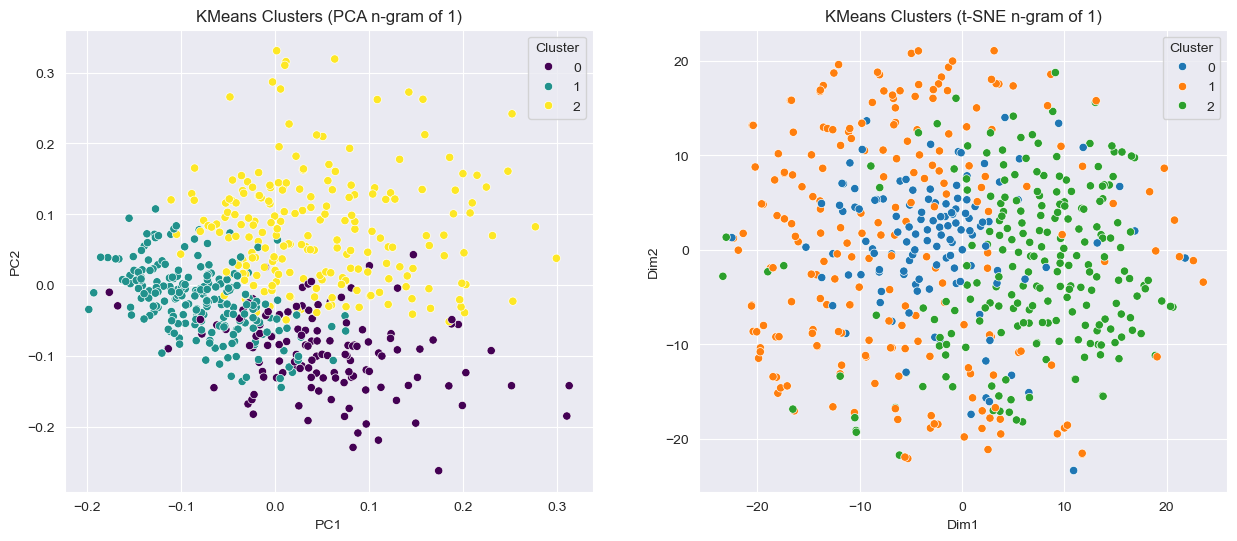

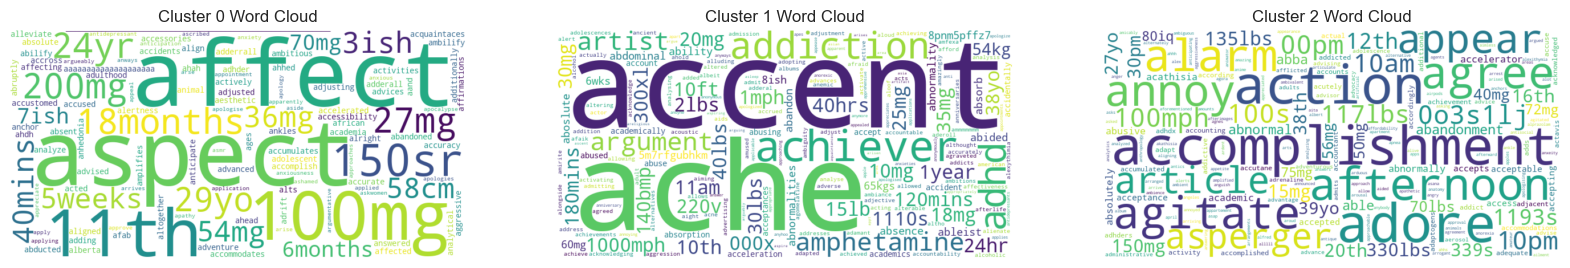

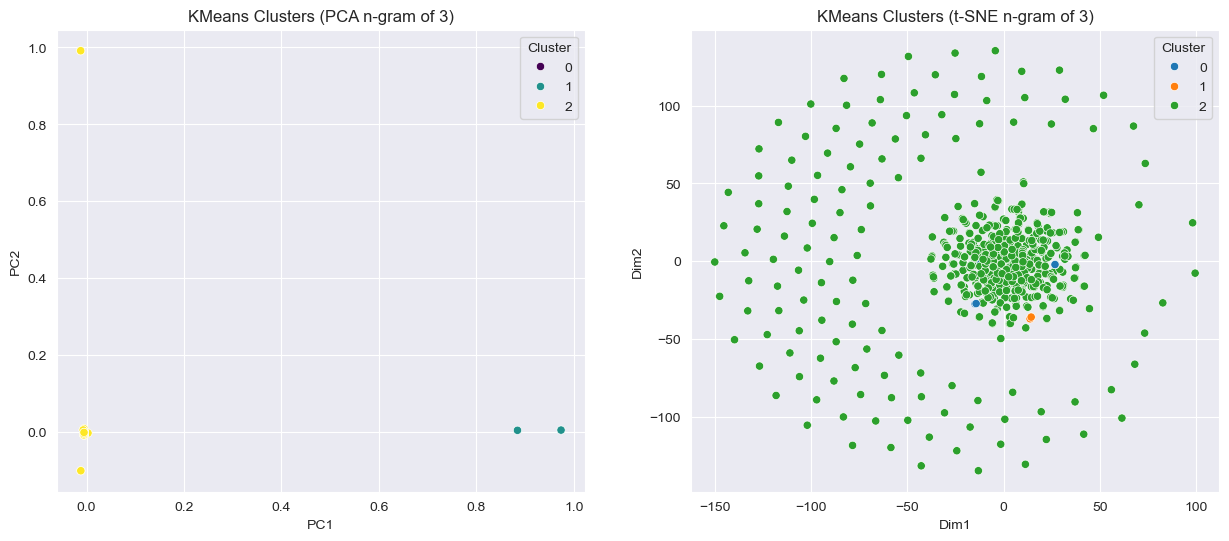

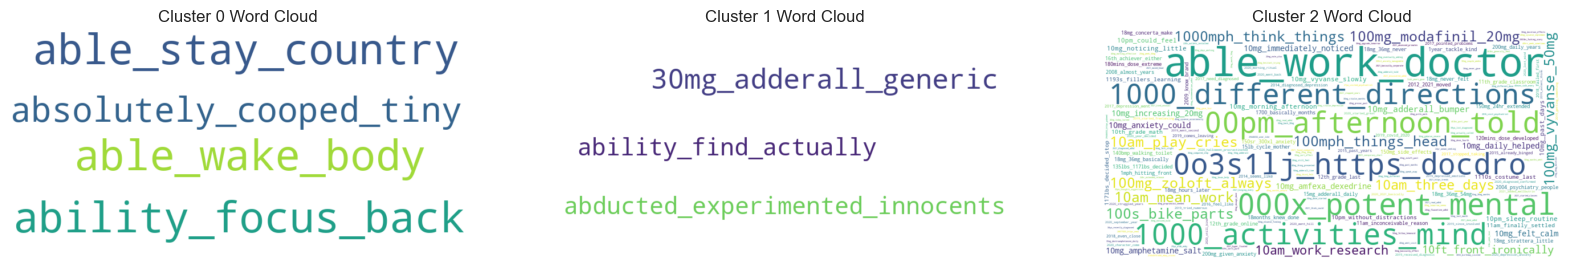

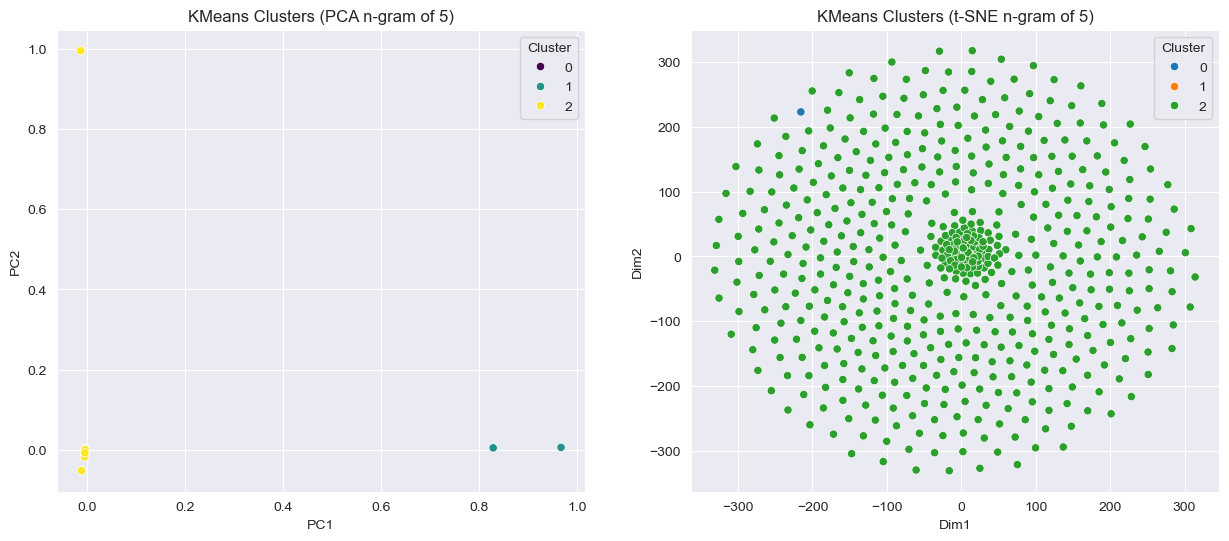

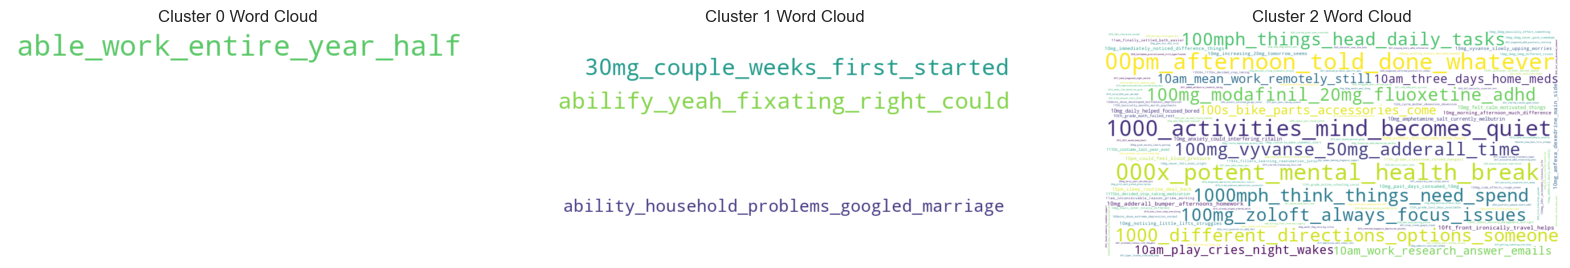

In [18]:
def run(n):
    k = 3
    vectorizer = TfidfVectorizer(stop_words='english')
    X = getVectorizedData(df_clean, n, vectorizer)
    pca, tsne, word_cluster = prepare_plot_data(X, k, vectorizer)

    # Get the most common words
    most_common_words = tuple(pd.Series(vectorizer.vocabulary_)
                              .sort_values(ascending=False)
                              .head(10)
                              .items())

    plot_data(pca, tsne, f"n-gram of {n}")
    plot_wordcloud(word_cluster, k)

    return most_common_words

# Put raw data into a dataframe
df = pd.read_csv(adhd_csv)
# Filter items that include the comparison_list in the body
df_clean = df[df["body"].str.contains('|'.join(comparison_list), case=False, na=False)]


m1 = run(1)
m3 = run(3)
m5 = run(5)